# First Intention Step Analysis - Main Comparison Figure

This notebook generates the main comparison figure for first intention steps between individual and joint RL agent conditions.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

In [22]:
# Load and prepare data
data_dir = Path('data')
excel_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_file(file_path):
    """Load Excel file and add metadata"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        df = df.assign(participantID=participant_id)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all files
data_frames = [load_and_process_file(f) for f in excel_files if load_and_process_file(f) is not None]
combined_data = pd.concat(data_frames, ignore_index=True)

# Include both 1P2G and 2P3G experiments for comparison
filtered_data = combined_data[combined_data['experimentType'].isin(['1P2G', '2P3G'])].copy()
print(f"Data loaded: {len(filtered_data)} trials from {filtered_data['participantID'].nunique()} participants")
print(f"Experiment types: {filtered_data['experimentType'].value_counts()}")

Data loaded: 1440 trials from 60 participants
Experiment types: experimentType
1P2G    720
2P3G    720
Name: count, dtype: int64


In [23]:
# Calculate first intention steps for both experiment types
def calculateFirstIntentionStep(goalList):
    """Finds the step where first intention appears (first non-null value)"""
    for i, goal in enumerate(goalList):
        if goal is not None:
            return i + 1  # Return 1-indexed step
    return len(goalList)  # No intention found

def safe_parse_goal_list(goal_data):
    """Safely parse goal data from various formats"""
    try:
        if pd.isna(goal_data) or goal_data is None or goal_data == '[]':
            return []
        if isinstance(goal_data, str) and goal_data.startswith('['):
            goal_data_clean = goal_data.replace('null', 'None')
            goal_list = eval(goal_data_clean)
            return goal_list
        return []
    except:
        return []

def calculate_first_intention_step(goal_data):
    """Calculate first intention step"""
    try:
        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result < len(goal_list) else np.nan
    except:
        return np.nan

# Apply the calculation to all experiment types
filtered_data['firstIntentionStep'] = filtered_data['player1CurrentGoal'].apply(calculate_first_intention_step)

# Filter to valid data for analysis
plot_data = filtered_data.dropna(subset=['firstIntentionStep']).copy()
print(f"Valid data for analysis: {len(plot_data)} trials")
print(f"By experiment type: {plot_data['experimentType'].value_counts()}")

Valid data for analysis: 1440 trials
By experiment type: experimentType
1P2G    720
2P3G    720
Name: count, dtype: int64


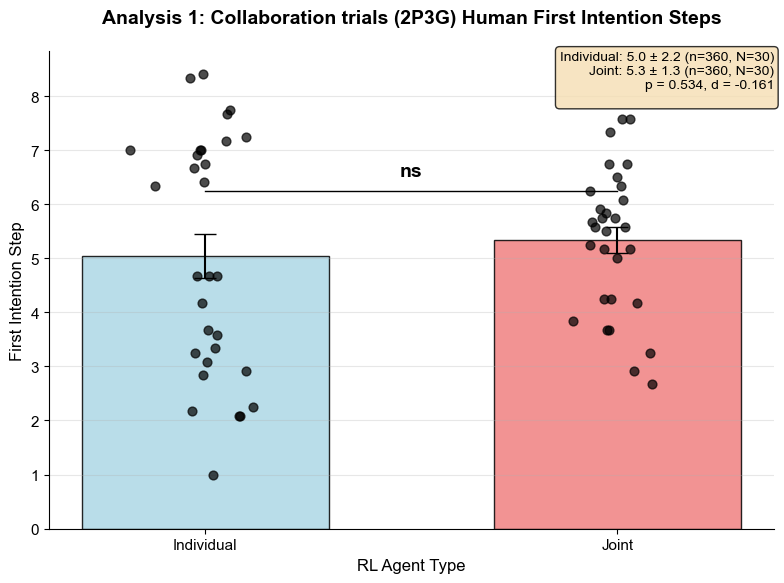

In [24]:
# Analysis 1: Focus on 2P3G - Individual vs Joint comparison (Bar Plot)
# Filter to 2P3G data only
data_2p3g = plot_data[plot_data['experimentType'] == '2P3G'].copy()

if len(data_2p3g) > 0:
    # Calculate participant-level means for 2P3G
    participant_means_2p3g = data_2p3g.groupby(['participantID', 'rlAgentType'])['firstIntentionStep'].mean().reset_index()

    individual_2p3g = participant_means_2p3g[participant_means_2p3g['rlAgentType'] == 'individual']['firstIntentionStep']
    joint_2p3g = participant_means_2p3g[participant_means_2p3g['rlAgentType'] == 'joint']['firstIntentionStep']

    # Get trial-level data for plotting
    trial_individual_2p3g = data_2p3g[data_2p3g['rlAgentType'] == 'individual']['firstIntentionStep']
    trial_joint_2p3g = data_2p3g[data_2p3g['rlAgentType'] == 'joint']['firstIntentionStep']

    # Statistical test for 2P3G
    if len(individual_2p3g) > 0 and len(joint_2p3g) > 0:
        t_stat, p_value = stats.ttest_ind(individual_2p3g, joint_2p3g)
        pooled_std = np.sqrt(((len(individual_2p3g) - 1) * individual_2p3g.std()**2 +
                             (len(joint_2p3g) - 1) * joint_2p3g.std()**2) /
                            (len(individual_2p3g) + len(joint_2p3g) - 2))
        cohens_d = (individual_2p3g.mean() - joint_2p3g.mean()) / pooled_std
    else:
        t_stat, p_value, cohens_d = np.nan, np.nan, np.nan

    # Prepare data for bar plot (mean and SEM)
    bar_data = participant_means_2p3g.groupby('rlAgentType')['firstIntentionStep'].agg(['mean', 'std', 'count']).reset_index()
    bar_data['sem'] = bar_data['std'] / np.sqrt(bar_data['count'])

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Bar plot with error bars (SEM)
    bar_colors = ['lightblue', 'lightcoral']
    ax.bar(
        bar_data['rlAgentType'],
        bar_data['mean'],
        yerr=bar_data['sem'],
        capsize=8,
        color=bar_colors,
        edgecolor='black',
        width=0.6,
        alpha=0.85
    )

    # Overlay individual participant means as scatter
    for i, rl_type in enumerate(['individual', 'joint']):
        y_vals = participant_means_2p3g[participant_means_2p3g['rlAgentType'] == rl_type]['firstIntentionStep']
        x_vals = np.random.normal(i, 0.06, size=len(y_vals))  # jitter
        ax.scatter(x_vals, y_vals, color='black', alpha=0.7, s=40, zorder=10)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Statistical significance annotation
    if not np.isnan(p_value):
        sig_text = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        y_max = bar_data['mean'].max() + bar_data['sem'].max()
        ax.plot([0, 1], [y_max + 0.5, y_max + 0.5], 'k-', linewidth=1)
        ax.text(0.5, y_max + 0.7, sig_text, ha='center', va='bottom', fontsize=14, fontweight='bold')

    ax.set_title('Analysis 1: Collaboration trials (2P3G) Human First Intention Steps', fontweight='bold', pad=20)
    ax.set_ylabel('First Intention Step')
    ax.set_xlabel('RL Agent Type')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Individual', 'Joint'])
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistics text
    if len(individual_2p3g) > 0 and len(joint_2p3g) > 0:
        textstr = f'Individual: {individual_2p3g.mean():.1f} ± {individual_2p3g.std():.1f} (n={len(trial_individual_2p3g)}, N={len(individual_2p3g)})\n'
        textstr += f'Joint: {joint_2p3g.mean():.1f} ± {joint_2p3g.std():.1f} (n={len(trial_joint_2p3g)}, N={len(joint_2p3g)})\n'
        textstr += f'p = {p_value:.3f}, d = {cohens_d:.3f}\n'

        ax.text(1, 1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    # ##  # plt.savefig('analysis1_2p3g_individual_vs_joint_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No 2P3G data available for analysis")

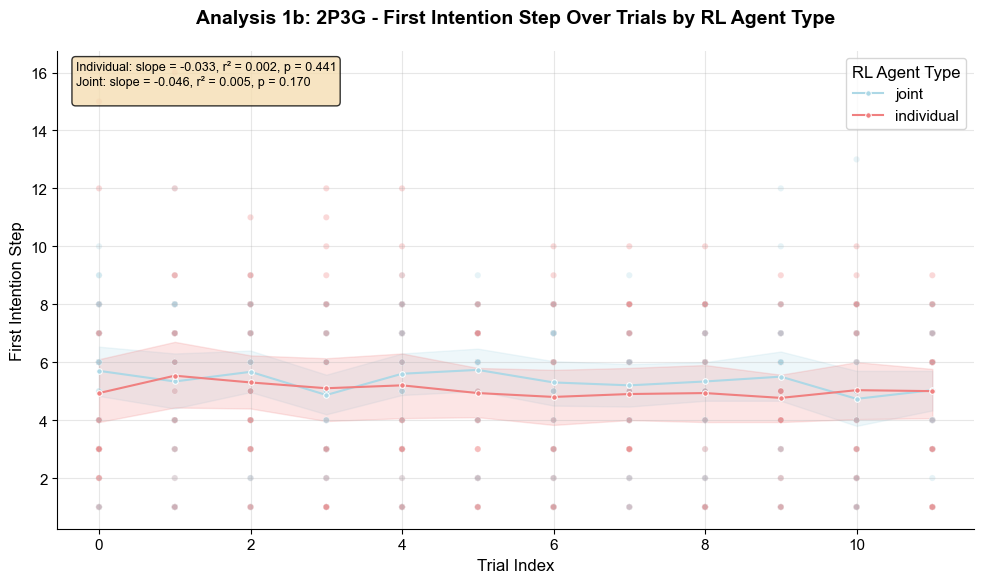

In [25]:
# Analysis 1b: 2P3G - First intention step as function of trial index by RL agent type
if len(data_2p3g) > 0:
    # Create trial index if it doesn't exist (assuming trials are in order)
    if 'trialIndex' not in data_2p3g.columns:
        data_2p3g_indexed = data_2p3g.copy()
        data_2p3g_indexed['trialIndex'] = data_2p3g_indexed.groupby(['participantID', 'rlAgentType']).cumcount() + 1
    else:
        data_2p3g_indexed = data_2p3g.copy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Line plot with confidence intervals
    sns.lineplot(data=data_2p3g_indexed, x='trialIndex', y='firstIntentionStep', hue='rlAgentType',
                ax=ax, palette=['lightblue', 'lightcoral'], marker='o', markersize=4,
                err_style='band', ci=95)

    # Scatter plot overlay
    sns.scatterplot(data=data_2p3g_indexed, x='trialIndex', y='firstIntentionStep', hue='rlAgentType',
                   ax=ax, palette=['lightblue', 'lightcoral'], alpha=0.3, s=20, legend=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title('Analysis 1b: 2P3G - First Intention Step Over Trials by RL Agent Type', fontweight='bold', pad=20)
    ax.set_ylabel('First Intention Step')
    ax.set_xlabel('Trial Index')
    ax.grid(True, alpha=0.3)
    ax.legend(title='RL Agent Type', loc='upper right')

    # Add trend analysis
    from scipy.stats import linregress
    textstr = ""
    for rl_type in ['individual', 'joint']:
        subset = data_2p3g_indexed[data_2p3g_indexed['rlAgentType'] == rl_type]
        if len(subset) > 2:
            slope, intercept, r_value, p_value, std_err = linregress(subset['trialIndex'], subset['firstIntentionStep'])
            textstr += f"{rl_type.capitalize()}: slope = {slope:.3f}, r² = {r_value**2:.3f}, p = {p_value:.3f}\n"

    if textstr:
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    # ##  # plt.savefig('analysis1b_2p3g_trials_by_rl_agent.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No 2P3G data available for trial analysis")

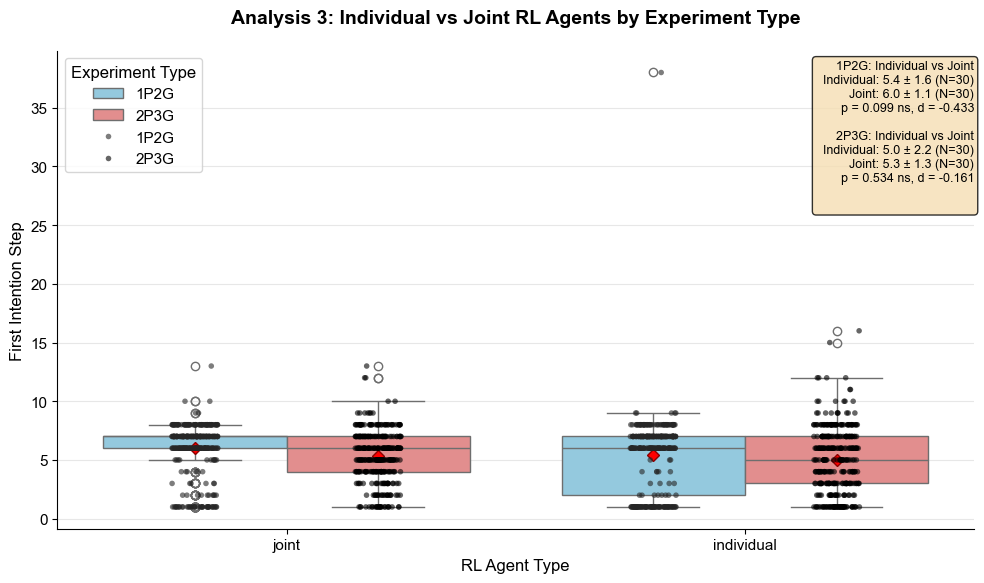

In [26]:
# Analysis 3: Individual vs Joint with experiment type as hue
# Calculate participant-level means for individual vs joint with experiment type breakdown
participant_means_full = plot_data.groupby(['participantID', 'rlAgentType', 'experimentType'])['firstIntentionStep'].mean().reset_index()

# Statistical tests for individual vs joint within each experiment type
combinations = []
for exp_type in ['1P2G', '2P3G']:
    exp_data = participant_means_full[participant_means_full['experimentType'] == exp_type]
    individual_data = exp_data[exp_data['rlAgentType'] == 'individual']['firstIntentionStep']
    joint_data = exp_data[exp_data['rlAgentType'] == 'joint']['firstIntentionStep']

    if len(individual_data) > 0 and len(joint_data) > 0:
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)
        pooled_std = np.sqrt(((len(individual_data) - 1) * individual_data.std()**2 +
                             (len(joint_data) - 1) * joint_data.std()**2) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std
        combinations.append({
            'exp_type': exp_type,
            'individual_mean': individual_data.mean(),
            'individual_std': individual_data.std(),
            'joint_mean': joint_data.mean(),
            'joint_std': joint_data.std(),
            'p_value': p_value,
            'cohens_d': cohens_d,
            'n_individual': len(individual_data),
            'n_joint': len(joint_data)
        })

# Create Individual vs Joint with experiment type as hue
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Box plot with experiment type as hue
box_plot = sns.boxplot(data=plot_data, x='rlAgentType', y='firstIntentionStep', hue='experimentType',
                      ax=ax, palette=['skyblue', 'lightcoral'],
                      showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

sns.stripplot(data=plot_data, x='rlAgentType', y='firstIntentionStep', hue='experimentType',
             ax=ax, size=4, alpha=0.6, dodge=True, color='black')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Analysis 3: Individual vs Joint RL Agents by Experiment Type', fontweight='bold', pad=20)
ax.set_ylabel('First Intention Step')
ax.set_xlabel('RL Agent Type')
ax.grid(True, alpha=0.3, axis='y')

# Add statistics text for each experiment type
textstr = ""
for combo in combinations:
    sig_text = "***" if combo['p_value'] < 0.001 else "**" if combo['p_value'] < 0.01 else "*" if combo['p_value'] < 0.05 else "ns"
    textstr += f"{combo['exp_type']}: Individual vs Joint\n"
    textstr += f"  Individual: {combo['individual_mean']:.1f} ± {combo['individual_std']:.1f} (N={combo['n_individual']})\n"
    textstr += f"  Joint: {combo['joint_mean']:.1f} ± {combo['joint_std']:.1f} (N={combo['n_joint']})\n"
    textstr += f"  p = {combo['p_value']:.3f} {sig_text}, d = {combo['cohens_d']:.3f}\n\n"

if textstr:
    ax.text(1, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Adjust legend
ax.legend(title='Experiment Type', loc='upper left')

plt.tight_layout()
# ##  # plt.savefig('analysis3_individual_vs_joint_by_experiment.png', dpi=300, bbox_inches='tight')
plt.show()

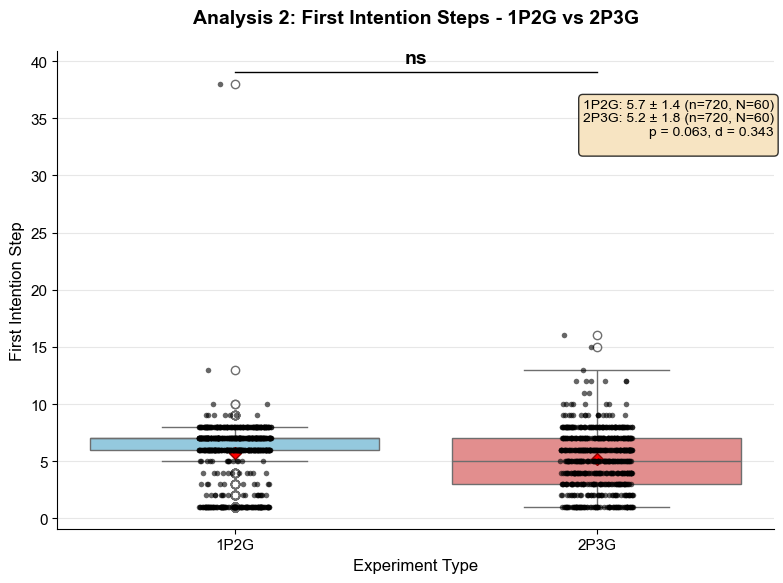

In [27]:
# Analysis 2: Compare 1P2G vs 2P3G experiment types
# Calculate participant-level means by experiment type
participant_means_exp = plot_data.groupby(['participantID', 'experimentType'])['firstIntentionStep'].mean().reset_index()

# Get data for each experiment type
data_1p2g_exp = participant_means_exp[participant_means_exp['experimentType'] == '1P2G']['firstIntentionStep']
data_2p3g_exp = participant_means_exp[participant_means_exp['experimentType'] == '2P3G']['firstIntentionStep']

# Get trial-level data for plotting
trial_1p2g_exp = plot_data[plot_data['experimentType'] == '1P2G']['firstIntentionStep']
trial_2p3g_exp = plot_data[plot_data['experimentType'] == '2P3G']['firstIntentionStep']

# Statistical test between experiment types
if len(data_1p2g_exp) > 0 and len(data_2p3g_exp) > 0:
    t_stat, p_value = stats.ttest_ind(data_1p2g_exp, data_2p3g_exp)
    pooled_std = np.sqrt(((len(data_1p2g_exp) - 1) * data_1p2g_exp.std()**2 +
                         (len(data_2p3g_exp) - 1) * data_2p3g_exp.std()**2) /
                        (len(data_1p2g_exp) + len(data_2p3g_exp) - 2))
    cohens_d = (data_1p2g_exp.mean() - data_2p3g_exp.mean()) / pooled_std
else:
    t_stat, p_value, cohens_d = np.nan, np.nan, np.nan

# Create experiment type comparison figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Box plot comparing 1P2G vs 2P3G
box_plot = sns.boxplot(data=plot_data, x='experimentType', y='firstIntentionStep',
                      ax=ax, palette=['skyblue', 'lightcoral'],
                      showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

sns.stripplot(data=plot_data, x='experimentType', y='firstIntentionStep',
             ax=ax, size=4, alpha=0.6, color='black')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Statistical significance annotation
if not np.isnan(p_value):
    sig_text = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    y_max = plot_data['firstIntentionStep'].max()
    ax.plot([0, 1], [y_max + 1, y_max + 1], 'k-', linewidth=1)
    ax.text(0.5, y_max + 1.5, sig_text, ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_title('Analysis 2: First Intention Steps - 1P2G vs 2P3G', fontweight='bold', pad=20)
ax.set_ylabel('First Intention Step')
ax.set_xlabel('Experiment Type')
ax.grid(True, alpha=0.3, axis='y')

# Add statistics text
if len(data_1p2g_exp) > 0 and len(data_2p3g_exp) > 0:
    textstr = f'1P2G: {data_1p2g_exp.mean():.1f} ± {data_1p2g_exp.std():.1f} (n={len(trial_1p2g_exp)}, N={len(data_1p2g_exp)})\n'
    textstr += f'2P3G: {data_2p3g_exp.mean():.1f} ± {data_2p3g_exp.std():.1f} (n={len(trial_2p3g_exp)}, N={len(data_2p3g_exp)})\n'
    textstr += f'p = {p_value:.3f}, d = {cohens_d:.3f}\n'

    ax.text(1, 0.9, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
# ##  # plt.savefig('analysis2_1p2g_vs_2p3g.png', dpi=300, bbox_inches='tight')
plt.show()